# Train 3D network on Memento

In [1]:
# Imports
import sys
print("sys.executable:",sys.executable)

import numpy as np
import keras
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from keras.optimizers import Adam, SGD
import pickle
import json

sys.path.append('../src/')
from generator import VideoSeqGenerator, preprocess_rgb_fast, load_vids_opencv
from vid_utils import load_video_opencv, plot_frames
from memento_utils import *
from captioning_utils import *
import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2


# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

sys.executable: /usr/bin/python3


Using TensorFlow backend.
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
import keras
import tensorflow as tf
import numpy as np
print("keras version:", keras.__version__)
print("tf version:", tf.__version__)
print("np version:", np.__version__)

keras version: 2.3.1
tf version: 1.14.0
np version: 1.18.1


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [4]:
%%bash
nvidia-smi

Wed Mar  4 02:22:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:1A:00.0 Off |                  N/A |
| 41%   34C    P8    24W / 280W |  23131MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           On   | 00000000:68:00.0  On |                  N/A |
| 41%   43C    P0    69W / 280W |   1927MiB / 24212MiB |     13%      Default |
+-------------------------------+----------------------+----------------------+
        

In [5]:
# Generate updated mem_score_file

# Key vars

In [6]:
data_type = 'rgb'
dataset = 'memento10k'
gpus = 1
resc = 1
use_sw = 0
bs = 12
do = 0.3
loss_type = 'alphamse'

# Fetch video names, alphas, memorability scores and captions


In [7]:
if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if data_type=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
elif os.uname()[1] == 'cfosco-lambda':
    data_path = '../../../../../../Datasets/memento_raw/sources_numpy_256/' if data_type=='rgb' else '../../../../../../Datasets/memento_raw/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
else:
    data_path = '../../memento'
    labels_path = '../../memento_data'
    names_with_slash = True

    
caption_format='index_list'
    
# Fetch scores from ground truth json file with a defined T
T = 80
mem_scores_file = 'normalized_mem_scores_ma_T=%d.json' % T
alpha_file = 'alphas_ma_T=%d.json' % T


name_to_mem_alpha, name_to_mem, name_to_alpha =  get_name_to_mem_dict(mem_scores_file, 
                                                                 alpha_file, 
                                                                 labels_path, 
                                                                 names_with_slash=names_with_slash)

# print(name_to_mem_alpha)

train_names, val_names = get_train_test_sets_from_json(os.path.join(labels_path, 'memento_train_val_test.json'), 
                                             names_with_slash=names_with_slash)


input_captions_train, target_captions_train = prepare_caption_data('../../memento_data/memento_train_tokenized_captions.json', 
                                                                   word_embeddings='../../memento_data/vocab_embedding.json',
                                                                   return_backward=False, 
                                                                   caption_format=caption_format,
                                                                  names_with_slash=names_with_slash)

input_captions_val, target_captions_val = prepare_caption_data('../../memento_data/memento_val_tokenized_captions.json', 
                                                                   word_embeddings='../../memento_data/vocab_embedding.json',
                                                                   return_backward=False, 
                                                                   caption_format=caption_format,
                                                                  names_with_slash=names_with_slash)

embedding_matrix = get_embedding_matrix('../../memento_data/vocab_embedding.json',
                                        '../../memento_data/vocab.json')

print("embedding_matrix.shape:",embedding_matrix.shape)


## FUSE LABEL_DICTIONARIES
str2label_train = add_caption_to_str2label(name_to_mem_alpha, target_captions_train)
str2label_val = add_caption_to_str2label(name_to_mem_alpha, target_captions_val)

## DEBUG
# str2label_train= {}
# str2label_val= {}
# t = np.linspace(40,180,8).reshape(-1,1)
# for name,(m,al) in name_to_mem_alpha.items():
# #     print(name, m, al)
#     str2label_train[name] =  np.array((t-T)*al + m)
#     str2label_val[name] =  np.array((t-T)*al + m)

t = np.linspace(40,180,8).reshape(-1,1)
for name, labels in str2label_train.items():
    print(labels)
    m = labels[0]
    al = labels[1]
    str2label_train[name][0] =  np.array((t-T)*al + m)
for name, labels in str2label_val.items():  
    print(labels)  
    m = labels[0]
    al = labels[1]
    str2label_val[name][0] =  np.array((t-T)*al + m)


i=0
for k,v in str2label_train.items():
    print(k)
#     print([to_words(c) for c in v[2]])
    print(v[0])
    i+=1
    if i >10:
        break

# for k,v in input_captions_train.items():
#     print(k)
#     print(len(v))
#     for cap in v:
#         for word in cap:
#             print(word)
#     break

print('Loaded %d train videos and %d val videos\n' % (len(train_names), len(val_names)))
 
# Check if all names are in dict
train_not_in_dict=0
for tn in train_names:
    if tn not in input_captions_train.keys():
        print('Train vid not in dict:',tn)
        train_not_in_dict+=1
print('train_not_in_dict',train_not_in_dict)
        
val_not_in_dict=0
for tn in val_names:
    if tn not in input_captions_val.keys():
        print('Val vid not in dict:',tn)
        val_not_in_dict+=1
print("val_not_in_dict",val_not_in_dict)
        

embedding_matrix.shape: (3873, 300)
[0.8131425965704244, -0.0010283298350488217, [[3, 21, 485, 11, 264, 2376, 419, 11, 2500, 17, 711, 6, 664, 3238, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [60, 9, 347, 419, 11, 2500, 3, 24, 39, 8, 4, 120, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [119, 14, 2254, 3, 24, 7, 40, 39, 8, 4, 120, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [60, 9, 2254, 3, 24, 39, 2254, 70, 1280, 108, 4, 55, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 26, 1270, 419, 11, 2500, 3, 24, 7, 40, 39, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]
[0.7922472089748855, -0.0013919177130145967, [[3, 40, 1242, 10, 3, 237, 193, 7, 6

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Plot distribution of words in the training examples

counts={}
word2idx={}

counts[0]=0

for i,w in enumerate(json.load(open('../../memento_data/vocab.json'))):
    counts[i+1]=0
    word2idx[w]=i+1
    

i=0
for k,v in target_captions_train.items():
    for caption in v:
        for w in caption:
#             if not w: continue
            counts[w]+=1
        
print(len(counts), len(embedding_matrix))
print("Counts of word 'a'", counts[2985])
print("Counts of padding token", counts[0])
print("Counts of <end> token (also number of total captions)", counts[2987])
print("Sum of all counts:", np.sum(list(counts.values())))

# plt.figure(figsize=[3,600])
# plt.barh([to_words(k) for k in list(counts.keys())], counts.values())
# plt.show()

3873 3873
Counts of word 'a' 7
Counts of padding token 1268442
Counts of <end> token (also number of total captions) 7
Sum of all counts: 1751000


In [9]:
cts = np.array([counts[i] for i in range(len(counts))])
freq=cts/np.sum(cts)
logfreq = np.log(freq)
logfreq[np.argmax(cts==0)] = -1e5
print("logfreq",logfreq, "len(logfreq)", len(logfreq))
    
word_weights={}
for i,c in enumerate(cts):
    word_weights[i] = 1/c if c!=0 else 0

# 'a'= 2985
print("For word a: freq[2985] = %.7f, word_weights[2985] = %.7f " %(freq[2985], word_weights[2985]))

# plt.figure(figsize=[5,600])
# plt.barh([to_words(k) for k in list(word_weights.keys())], word_weights.values())
# plt.show()

logfreq [-3.22397678e-01 -1.00000000e+05 -3.91202301e+00 ... -1.27662597e+01
 -1.27662597e+01 -1.27662597e+01] len(logfreq) 3873
For word a: freq[2985] = 0.0000040, word_weights[2985] = 0.1428571 


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


## Get mem weights if needed

In [10]:
if use_sw:
    factor = 3
    mem_weights = get_sample_weights([name_to_mem_alpha[n][0] for n in train_names], factor=factor)
    alpha_weights = get_sample_weights([name_to_mem_alpha[n][1] for n in train_names], factor=factor)
    
    sw=np.array(mem_weights)
else:
    sw=None

In [11]:
print([name_to_mem_alpha[n] for n in train_names][:10])
# print(mem_weights[:10])

[array([ 9.48476729e-01, -4.06758125e-04]), array([9.52842671e-01, 3.95002992e-04]), array([ 8.80173717e-01, -5.27162394e-04]), array([ 9.48841329e-01, -1.70860478e-04]), array([ 8.80273874e-01, -6.45399333e-04]), array([ 8.69092724e-01, -5.44651119e-04]), array([ 8.40222107e-01, -5.97639817e-05]), array([ 8.90148820e-01, -4.67422721e-04]), array([ 9.56506170e-01, -3.53009291e-04]), array([ 0.48104424, -0.00132367])]


# Generator

In [12]:
# Instantiating generator

if caption_format=='index_triangular_matrix':
    load_func = load_npy_and_partial_caption
    load_labels_func = load_labels_mot_words

elif caption_format=='index_list':
    load_func = load_npy_and_full_caption
    load_labels_func = load_labels_mot_caption
preprocess_func = 'cap_fast_'+data_type
    

# load_func='npy_'+data_type
# load_labels_func='as_list'
# preprocess_func='fast_rgb'
# str2label= {}
# t = np.linspace(40,180,8).reshape(-1,1)
# for name,(m,al) in name_to_mem_alpha.items():
# #     print(name, m, al)
#     str2label[name] =  np.array((t-T)*al + m)

gen_train = VideoSeqGenerator(files=np.array(train_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv= None, 
                            augment= None, #['dropout', 'cutout'],
                            load_func=load_func,
                            load_labels_func=load_labels_func,
                            preprocess_func=preprocess_func,
                            remove_excess_files=False,
                            shuffle=True,
                            is_train=True,
                            verbose=True,
                            str2label_dict = str2label_train,
                            sample_weights=sw,
                             input_captions = input_captions_train)

gen_val = VideoSeqGenerator(files=np.array(val_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func=load_labels_func,
                            preprocess_func=preprocess_func,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label_val,
                            sample_weights=sw,
                           input_captions = input_captions_val)

gen_val_mini = VideoSeqGenerator(files=np.array(val_names)[:20],
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func=load_labels_func,
                            preprocess_func=preprocess_func,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label_val,
                            sample_weights=sw,
                           input_captions = input_captions_val)

Caution: batch_size (12) is not multiple of given dataset length (7004). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 7004 . Augmentation:  None
Caution: batch_size (12) is not multiple of given dataset length (1506). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 1506 . Augmentation:  None
Caution: batch_size (12) is not multiple of given dataset length (20). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 20 . Augmentation:  None


# Test Generator

cap label to network: (50, 3873)
Memorability scores over time: [[0.79341643]
 [0.76248634]
 [0.73155624]
 [0.70062615]
 [0.66969605]
 [0.63876596]
 [0.60783586]
 [0.57690577]]
Input caption to network: ['<start>', 'a', 'baseball', 'game', 'is', 'playing', 'with', 'the', 'crowd', 'cheering', 'together', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'baseball', 'game', 'is', 'playing', 'with', 'the', 'crowd', 'cheering', 'together', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


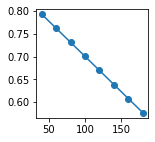

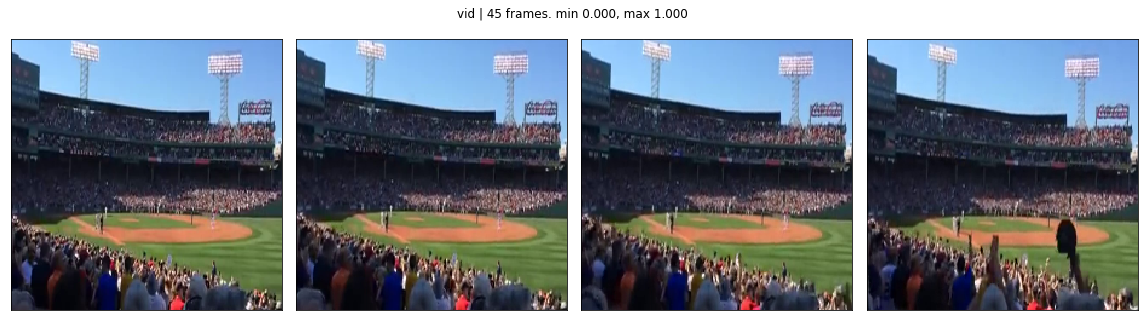

cap label to network: (50, 3873)
Memorability scores over time: [[0.88629622]
 [0.80216717]
 [0.71803813]
 [0.63390908]
 [0.54978003]
 [0.46565099]
 [0.38152194]
 [0.29739289]]
Input caption to network: ['<start>', 'a', 'soccer', 'game', 'with', 'players', 'in', 'white', 'uniforms', 'and', 'red', 'uniforms', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'soccer', 'game', 'with', 'players', 'in', 'white', 'uniforms', 'and', 'red', 'uniforms', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


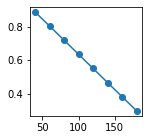

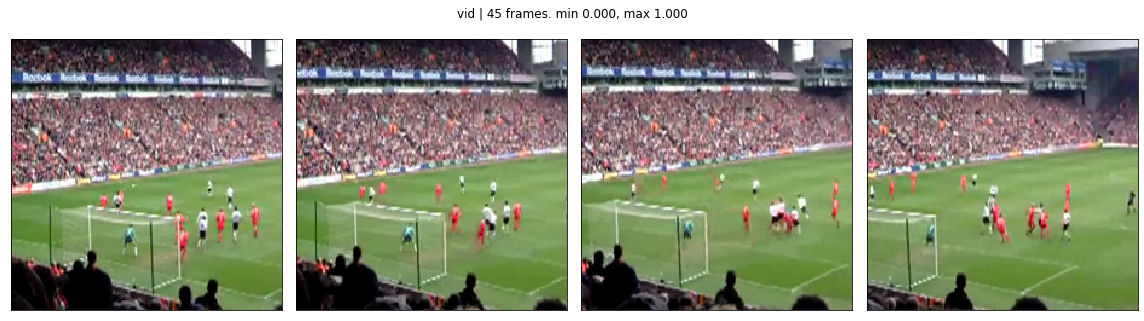

cap label to network: (50, 3873)
Memorability scores over time: [[0.87737213]
 [0.84799892]
 [0.8186257 ]
 [0.78925248]
 [0.75987927]
 [0.73050605]
 [0.70113284]
 [0.67175962]]
Input caption to network: ['<start>', 'an', 'elephant', 'is', 'dressed', 'up', 'and', 'wearing', 'something', 'on', 'his', 'face', 'people', 'wave', 'at', 'the', 'elephant', 'as', 'he', 'walks', 'past', 'with', 'someone', 'holding', 'a', 'leash', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['an', 'elephant', 'is', 'dressed', 'up', 'and', 'wearing', 'something', 'on', 'his', 'face', 'people', 'wave', 'at', 'the', 'elephant', 'as', 'he', 'walks', 'past', 'with', 'someone', 'holding', 'a', 'leash', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


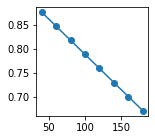

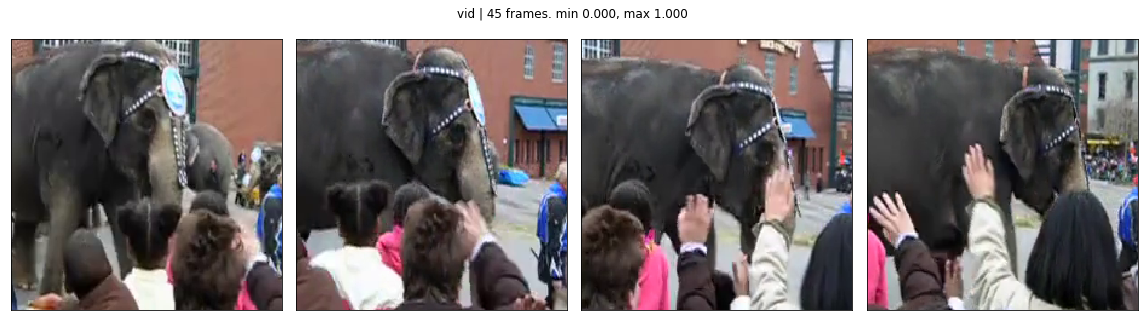

cap label to network: (50, 3873)
Memorability scores over time: [[0.93165767]
 [0.91643266]
 [0.90120765]
 [0.88598264]
 [0.87075764]
 [0.85553263]
 [0.84030762]
 [0.82508261]]
Input caption to network: ['<start>', 'a', 'team', 'of', 'cheerleaders', 'wearing', 'blue', 'perform', 'on', 'a', 'football', 'field', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'team', 'of', 'cheerleaders', 'wearing', 'blue', 'perform', 'on', 'a', 'football', 'field', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


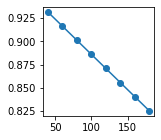

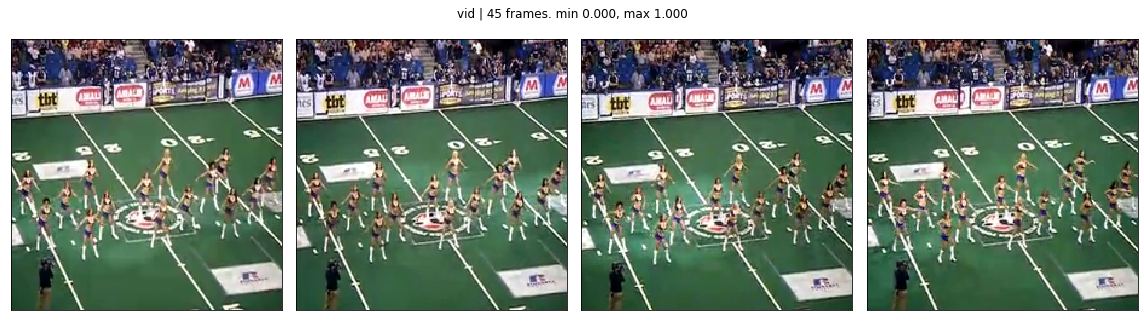

cap label to network: (50, 3873)
Memorability scores over time: [[0.78040627]
 [0.7404483 ]
 [0.70049032]
 [0.66053235]
 [0.62057437]
 [0.58061639]
 [0.54065842]
 [0.50070044]]
Input caption to network: ['<start>', 'a', 'performer', 'is', 'on', 'stage', 'with', 'a', 'united', 'states', 'flag', 'in', 'one', 'hand', 'and', 'a', 'microphone', 'in', 'the', 'other', 'hand', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'performer', 'is', 'on', 'stage', 'with', 'a', 'united', 'states', 'flag', 'in', 'one', 'hand', 'and', 'a', 'microphone', 'in', 'the', 'other', 'hand', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


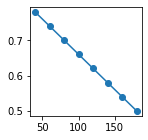

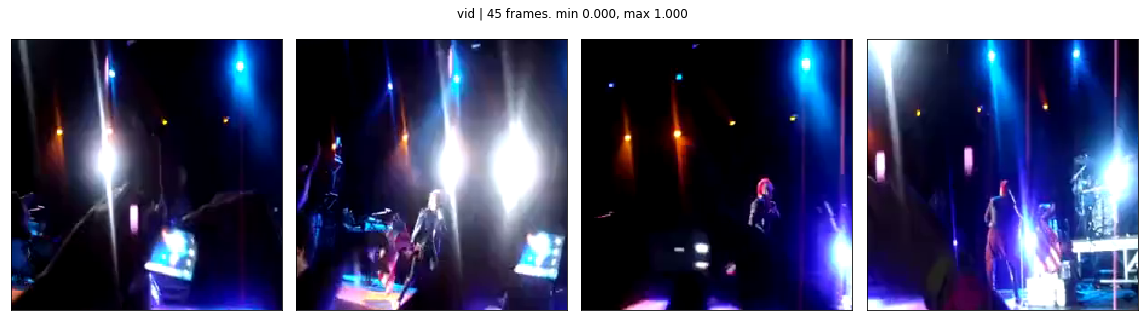

cap label to network: (50, 3873)
Memorability scores over time: [[0.66582133]
 [0.64895418]
 [0.63208704]
 [0.6152199 ]
 [0.59835275]
 [0.58148561]
 [0.56461847]
 [0.54775132]]
Input caption to network: ['<start>', 'a', 'performer', 'most', 'likely', 'a', 'throws', 'his', 'hands', 'up', 'in', 'the', 'air', 'with', 'the', 'crowd', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'performer', 'most', 'likely', 'a', 'throws', 'his', 'hands', 'up', 'in', 'the', 'air', 'with', 'the', 'crowd', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


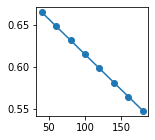

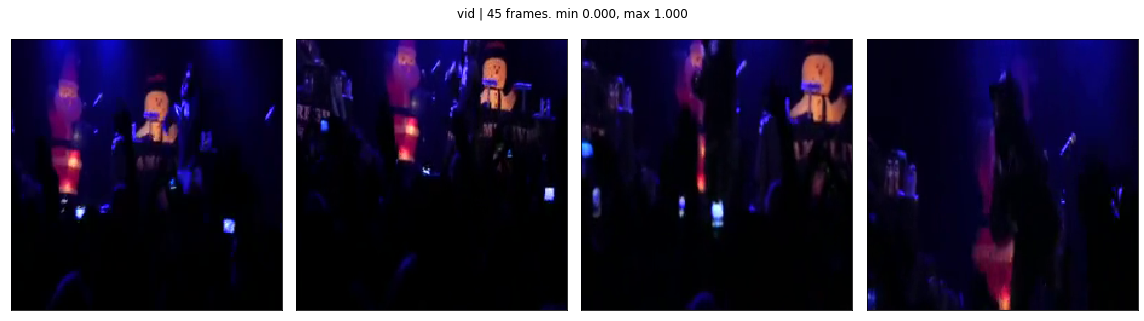

cap label to network: (50, 3873)
Memorability scores over time: [[0.86402646]
 [0.81797399]
 [0.77192152]
 [0.72586905]
 [0.67981658]
 [0.63376411]
 [0.58771163]
 [0.54165916]]
Input caption to network: ['<start>', 'a', 'band', 'performs', 'in', 'front', 'of', 'a', 'large', 'group', 'of', 'people', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'band', 'performs', 'in', 'front', 'of', 'a', 'large', 'group', 'of', 'people', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


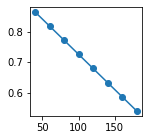

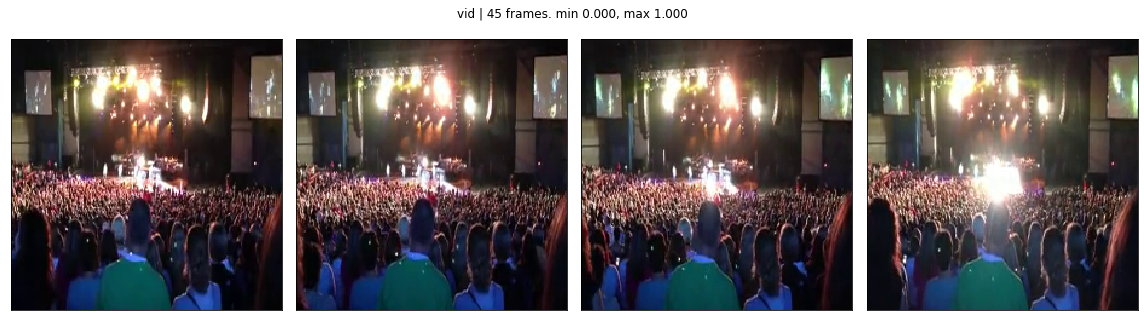

cap label to network: (50, 3873)
Memorability scores over time: [[0.63318183]
 [0.6266299 ]
 [0.62007798]
 [0.61352605]
 [0.60697413]
 [0.6004222 ]
 [0.59387028]
 [0.58731835]]
Input caption to network: ['<start>', 'a', 'large', 'group', 'of', 'people', 'wait', 'at', 'the', 'sidelines', 'of', 'a', 'football', 'field', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'large', 'group', 'of', 'people', 'wait', 'at', 'the', 'sidelines', 'of', 'a', 'football', 'field', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


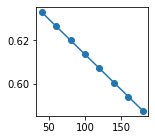

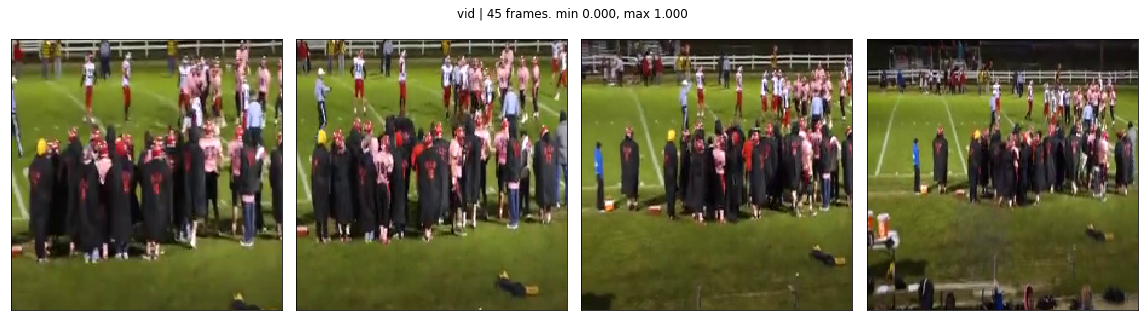

cap label to network: (50, 3873)
Memorability scores over time: [[0.73390035]
 [0.7134003 ]
 [0.69290025]
 [0.6724002 ]
 [0.65190015]
 [0.6314001 ]
 [0.61090005]
 [0.5904    ]]
Input caption to network: ['<start>', 'a', 'band', 'is', 'on', 'the', 'stage', 'performing', 'in', 'the', 'dark', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['a', 'band', 'is', 'on', 'the', 'stage', 'performing', 'in', 'the', 'dark', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


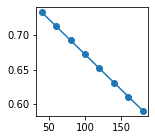

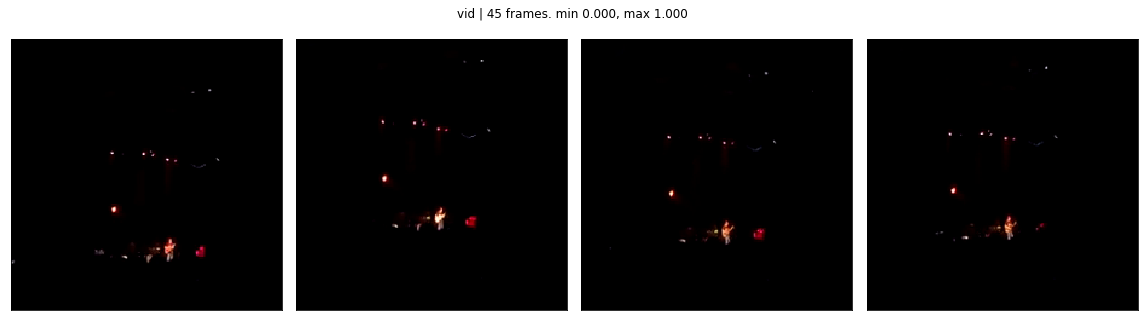

cap label to network: (50, 3873)
Memorability scores over time: [[0.90328621]
 [0.89382662]
 [0.88436703]
 [0.87490744]
 [0.86544785]
 [0.85598826]
 [0.84652868]
 [0.83706909]]
Input caption to network: ['<start>', 'two', 'people', 'standing', 'in', 'front', 'of', 'a', 'ski', 'jump', 'track', 'and', 'waving', 'a', 'flag', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['two', 'people', 'standing', 'in', 'front', 'of', 'a', 'ski', 'jump', 'track', 'and', 'waving', 'a', 'flag', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


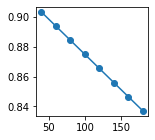

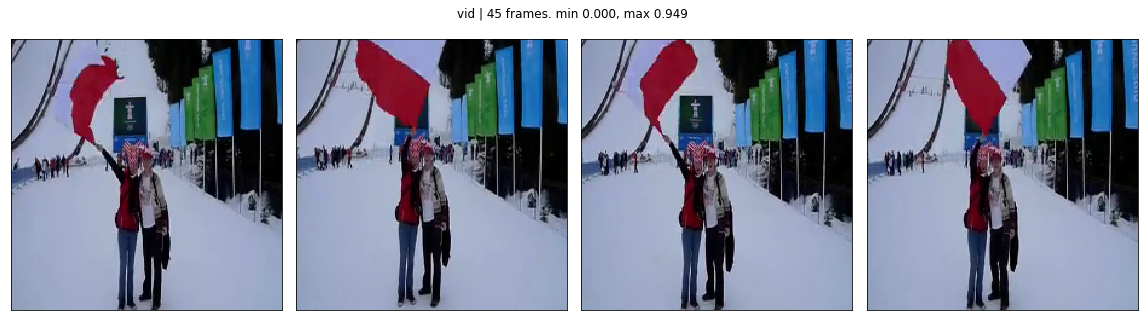

cap label to network: (50, 3873)
Memorability scores over time: [[0.83977368]
 [0.79730505]
 [0.75483643]
 [0.71236781]
 [0.66989918]
 [0.62743056]
 [0.58496194]
 [0.54249332]]
Input caption to network: ['<start>', 'many', 'people', 'are', 'holding', 'signs', 'while', 'listening', 'to', 'a', 'speaker', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['many', 'people', 'are', 'holding', 'signs', 'while', 'listening', 'to', 'a', 'speaker', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


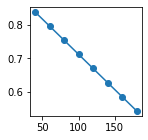

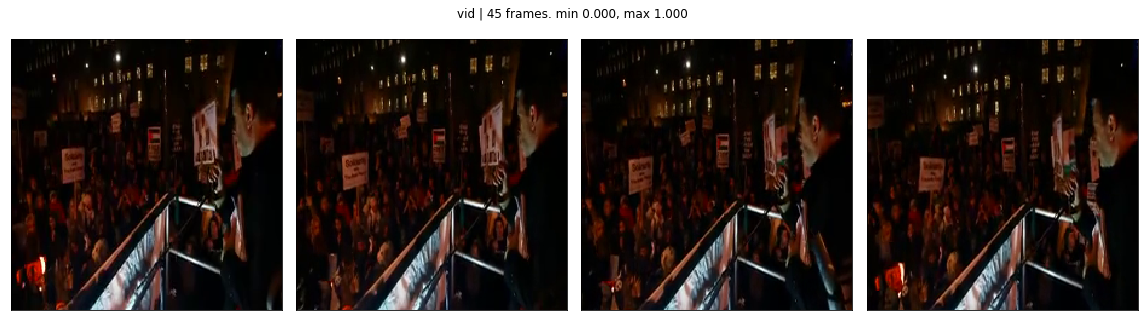

cap label to network: (50, 3873)
Memorability scores over time: [[0.85553931]
 [0.8572015 ]
 [0.85886368]
 [0.86052586]
 [0.86218804]
 [0.86385022]
 [0.8655124 ]
 [0.86717459]]
Input caption to network: ['<start>', 'at', 'a', 'run', 'and', 'track', 'stadium', 'a', 'woman', 'is', 'shouting', 'from', 'the', 'sidelines', 'and', 'a', 'young', 'boy', 'looks', 'at', 'her', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sentence to predict: ['at', 'a', 'run', 'and', 'track', 'stadium', 'a', 'woman', 'is', 'shouting', 'from', 'the', 'sidelines', 'and', 'a', 'young', 'boy', 'looks', 'at', 'her', '<end>', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


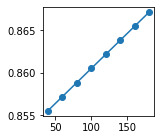

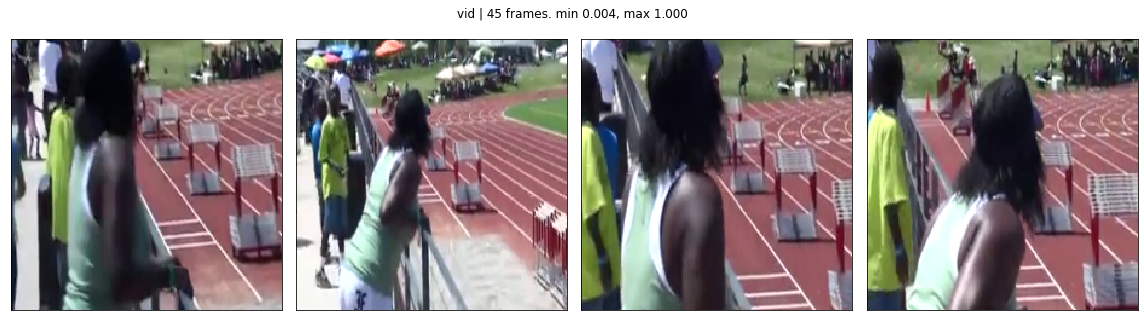

In [14]:
# Test with one batch of memento training

ret = gen_val.__getitem__(10) #np.random.randint(len(gen_val)))

video_batch=ret[0][0]
captions_batch = ret[0][1]
labels=ret[1]


# Display
for i,b in enumerate(video_batch):
    
    captions = captions_batch[i]
    
#     print("mot:", labels[i])
    mot = labels[0][i]
    cap_label = labels[1][i]
    print("cap label shape:", cap_label.shape)
    
    print("Memorability scores over time:",mot)
    plt.figure(figsize=[2,2])
    plt.plot(np.linspace(40,180,8), mot, marker='o')
    
    print("Input caption to network:", to_words(captions))
    if caption_format=='index_triangular_matrix':
        print("Word to predict:", to_words(np.argmax(cap_label)))
    elif caption_format=='index_list':    
        print("Sentence to predict:", to_words([np.argmax(w) for w in cap_label]))
    
    plot_frames(b, 
                title='%s | %d frames.' % ('vid',len(b)),
                is_optical_flow=True if data_type=='flow' else False,
                suptitle_y=0.89,
                is_255image=True, 
                frames_to_show=4)

# Model

In [25]:
# Fetching pretrained i3d

i3d = build_model_multigpu(type=data_type, 
                           model_type='i3d_rec_cap',
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=1,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=do, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=resc,
                           embedding_matrix=embedding_matrix,
                           output_biases=logfreq)


Working with single GPU
x.shape after downsa: (None, 23, 28, 28, 192)
channels_last
x.shape after last conv: (None, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /home/camilo/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
video_repr shape before last conv (None, 5, 1, 1, 1024)
Model: "i3d_full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 45, 224, 224, 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 45, 224, 224, 0           input_4[0][0]                    
__________________________________________________________________________________________________
i3d_inception (Model)           multiple             122

In [26]:
%%bash
cd ../ckpt/i3d_rec
ls

memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0135_valrc0.5605.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0155_valrc0.6124.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0177_valrc0.3365.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0184_valrc0.5815.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0125_valrc0.6117.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0165_valrc0.5636.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0179_valrc0.5835.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0185_valrc0.2243.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep03_valloss0.0095_valrc0.6078.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c10

In [27]:
# Load weights -  careful when loading ani3d_cap model: you might overwrite the initialized biases
W = None #'../ckpt/i3d_rec/memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep11_valloss0.0148_valrc0.6112.hdf5' #None # '../ckpt/i3d/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep07_valloss6.8248_valrc0.5935.hdf5' #None #'../ckpt/i3d/memento10k_flow_ep06_valloss8.8485.hdf5'
if W:
    i3d.load_weights(W, by_name=True)

In [17]:
# TESTING LOSS
# loss = loss_alpha_mse(print_=True)

# for i in range(5):
#     ret = gen_train.__getitem__(i)
#     batch = ret[0]
#     labels = ret[1]
#     preds = i3d.predict(batch)
#     loss(K.variable(labels), K.variable(preds))

# Train last layers

In [ ]:
### print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    if l.name == 'i3d_inception':
        l.trainable=False
    if l.name == 'Conv3d_6a_1x1_conv':
        l.trainable=False

# Define optimizer
lr=0.0001
optimizer = Adam(lr=lr)

print('Compiling model')

# Compile model
a=1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=['mse', 'categorical_crossentropy'],
              metrics=['mse','accuracy'])
    
preds_savefile = '../preds/i3d_rec_cap_%s_%s.pkl' % (data_type, dataset)

    
use_rc=True


true_mem = np.zeros((8,len(val_names)))
for i,v in enumerate(val_names):
    true_mem[:,i] = str2label_val[v][0].flatten()

ckpt_filepath = get_ckpt_name_cap('../ckpt/i3d_cap_rec', dataset, data_type, True, resc, gpus, bs, loss_type, use_sw, do, a,b,c, use_rc=use_rc)
cbs = define_callbacks(ckpt_filepath, 
                       gen_val, 
#                        name_to_mem_alpha, 
#                        val_names, 
                       true_mem=true_mem, 
                       lr=lr, 
                       drop=0.1, 
                       epochs_drop=10, 
                       ckpt_period=1, 
                       use_cb_rankcorr=use_rc,
                       preds_savefile=preds_savefile)


print('Ready to train last layer')
print('ckpt_filepath:',ckpt_filepath)

# Training
i3d.fit_generator(gen_train, 
                  epochs=15,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val, 
                  workers=1,
                  class_weight=word_weights)


# Train full network

In [ ]:
print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    l.trainable = True

        
lr=0.0001
optimizer = Adam(lr=lr)

a=1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=[loss_alpha_mse(a,b,c,bs=bs,T=T) if loss_type=='alphamse' else loss_alpha(bs=bs,T=T), 'categorical_crossentropy'],
              metrics=['accuracy'])
    
use_rc=True
ckpt_filepath = get_ckpt_name_cap('../ckpt/i3d_cap', dataset, data_type, False, resc, gpus, bs, loss_type, use_sw, do, a,b,c, use_rc=use_rc)
cbs = define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=1, use_cb_rankcorr=use_rc)


    
print('Ready to train full net')

# Training
i3d.fit_generator(gen_train, 
                  epochs=50,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val, 
                  workers=10,
                 class_weight=word_weights)


# Show some results

In [ ]:
def show_results(model, inputs, labels):
    
    preds = model.predict(inputs)
    
    mem_and_alpha = preds[0]
    captions = preds[1]
    
    for i in range(len(mem_and_alpha)):
        
        predmem = mem_and_alpha[i][0]
        predalpha = mem_and_alpha[i][1]
        
        mem = labels[0][i][0]
        alpha = labels[0][i][1]
        
        pred_cap = captions[i]
        true_cap = labels[1][i]
        
        # Show input video, predicted mem and alpha with true mem and alpha
        plot_frames(inputs[0][i], 
                    title='pred mem: %.3f. True: %.3f. pred alpha: %.5f. True: %.5f --' % (predmem, mem, predalpha, alpha),
                    is_optical_flow=False,
                    suptitle_y=0.89,
                    is_255image=True, 
                    frames_to_show=4)
        
        # Print predicted caption and true caption
        if caption_format=='index_triangular_matrix':
            print("Input caption:", to_words(inputs[1][i]))
            print("word to predict:", to_words(np.argmax(true_cap)))
            print("predicted word:", to_words(np.argmax(pred_cap)))
        else:
            print("Input caption:", to_words(inputs[1][i]))
            print("seq to predict:", to_words([np.argmax(w) for w in true_cap]))
            print("predicted seq:", to_words([np.argmax(w) for w in pred_cap]))
            
    
        
show_results(i3d, *gen_val.__getitem__(2))

# Generate captions

In [ ]:

word2idx['0']=0

def generate_captions_sentence(model, input_video, max_cap_len=50, verbose=True, gr_truth_cap = None):

#     print(gr_truth_cap, gr_truth_cap.shape)
    print(input_video.shape)
    if gr_truth_cap is not None:
        input_cap = gr_truth_cap
    else:
        input_cap = np.array([word2idx['<start>']])

    for i in range(max_cap_len-1):
#         print(to_words(input_cap[:i+1]))
        mem_alpha, cap = model.predict([[input_video], [input_cap[:i+1]]])
        print("prediction:", " ".join(to_words([np.argmax(w) for w in cap[0]])))
        predicted_word = np.argmax(cap[0][i])
        if gr_truth_cap is None:
            input_cap = np.append(input_cap,predicted_word)
#         if verbose: print("predicted word:", to_words(predicted_word))
        
        if predicted_word == word2idx['<end>']:
            break

    print("Final predicted caption:", " ".join(to_words(input_cap)))

    return input_cap

def generate_captions_wordbyword(ckpt):
    
    model = build_model_multigpu(type=data_type, 
                               model_type='i3d_cap_sentence_early',
                               image_size=cfg._IMAGE_SIZE,
                               num_frames=cfg._NUM_FRAMES, 
                               num_classes=2,
                               gpus=gpus,
                               use_pretrained=True, 
                               verbose=True, 
                               download_weights=True,
                               downsample_factor=None, 
                               dropout_prob=do, 
                               final_activation='tanh', 
                               show_internal_summary=False,
                               rescale=resc,
                               embedding_matrix=embedding_matrix,
                               output_biases=logfreq,
                               return_states=True )
    
    
#     model.load_weights(ckpt, by_name=True)
#     encoder = build_i3d
#     decoder = captioning_module
#     decoder = Model(inputs=[word,initial_states], outputs=[word, intial_states])
    

def predict_sentence_generator(gen, model, forcing=False, show_vid=True):
    captions=[]
    
    for inputs, labels in gen:

        for i in range(gen.batch_size):
            if show_vid:
                # Show input video, predicted mem and alpha with true mem and alpha
                plot_frames(inputs[0][i], 
                            title='%s -- True mem: %.3f. True alpha: %.5f --' % (" ".join(to_words(inputs[1][i])),labels[0][i][0],labels[0][i][1]),
                            is_optical_flow=False,
                            suptitle_y=0.95,
                            is_255image=True, 
                            frames_to_show=4)
            if forcing:
                captions.append(generate_captions_sentence(model, input_video=inputs[0][i], gr_truth_cap = list(inputs[1][i])))
            else:
                captions.append(generate_captions_sentence(model, input_video=inputs[0][i]))


            
    return captions


new_W = None # '../ckpt/i3d_cap/memento10k_rgb_fzn1_resc1_LTalphamse_a1b100c10_w0_gpus1_bs32_do0.30_ep18_valloss22.1719_capacc0.273.hdf5'
if new_W:
    i3d.load_weights(new_W, by_name=True)

predict_sentence_generator(gen_val, i3d, forcing=False)    

# Test embedding module

In [ ]:
from keras_models import captioning_module_with_emb_output
max_cap_len = 50

cap_model = captioning_module_with_emb_output(Input(shape=(max_cap_len,)), embedding_matrix)

k=3
pred, emb = cap_model.predict(np.array(range(max_cap_len)).reshape(1,-1))
print("Expected embedding:", embedding_matrix[0])
print("Predicted embedding:", emb[0][0])

In [ ]:
%%bash
cd ../ckpt/i3d_cap
ls

# Predict and Evaluate RC

In [ ]:
# Load model if necessary
W = '../ckpt/i3d_cap/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w0_gpus1_bs16_do0.30_ep01_valloss12.2976_valrc0.6052_capacc0.388.hdf5'
i3d.load_weights(W)

In [ ]:
# Predict

preds = i3d.predict_generator(gen_val, verbose=1)

In [ ]:

    pred_mem = [p[0] for p in preds]
    pred_alpha = [p[1] for p in preds]

    true_mem=[]
    true_alpha=[]

    verbose=False

    for i,n in enumerate(val_names[:-3]):
        if verbose:
            print('Name:',n)
            print('True mem:',name_to_mem_alpha[n][0])
            print('Pred mem:',pred_mem[i])
            print('True alpha:',name_to_mem_alpha[n][1])
            print('Pred alpha:',pred_alpha[i])
        true_mem.append(name_to_mem_alpha[n][0])
        true_alpha.append(name_to_mem_alpha[n][1])

    print('First 8 gt mem:', true_mem[:8])
    print('First 8 pred mem:', pred_mem[:8])

    # assert(len(preds)==len(val_names))

    rc = spearmanr(pred_mem, true_mem)
    alpha_rc = spearmanr(pred_alpha, true_alpha)
    

    print('RC:', rc[0])
    print('Alpha_rc:',alpha_rc[0])